In [1]:
%matplotlib inline
import nfldb
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle

from ml.feature_extraction.nfldb_feature_extraction import WeeklyPlayerData
from ml.feature_extraction.nfldb_feature_extraction import LagPlayerData
from ml.feature_extraction.nfldb_feature_extraction import MeanPlayerData
from ml.feature_extraction.nfldb_feature_extraction import ExtractColumns
from ml.feature_extraction.nfldb_feature_extraction import HandleNaN
from ml.feature_extraction.nfldb_feature_extraction import FilterPlayedPercent
from ml.helpers.nfldb_helpers import week_player_id_list
from ml.helpers.nfldb_helpers import player_current_game_info
from ml.helpers.scoring_helpers import make_scorer
from ml.helpers.scoring_helpers import score_stats
from ml.helpers.testing_helpers import train_test_split_index
from ml.helpers.testing_helpers import split_by_year_week

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


In [2]:
# connect to nfldb
db = nfldb.connect()
result_path = '../results'
cache_path = '../data'
position = 'RB'
load_cached = True

if(not load_cached):
    # make player data transformer
    yr_wk = [(j, i) for j in range(2009,2015) for i in range(1,18)]
    yr_wk += [(2015, i) for i in range(1,7)]

    #stats = ['rushing_yds','rushing_att']
    stats = ['receiving_rec', 'receiving_tar', 'receiving_tds', 'receiving_yac_yds', 'receiving_yds', 'rushing_att', 'rushing_tds','rushing_yds']

    player_info = ['player_id','full_name','position']
    playerData = WeeklyPlayerData(db=db, yr_wk=yr_wk, stats=stats, player_info=player_info, fill_time=True, position=position)

    # creates lags of the data
    lag_cols = ['year', 'week', 'played'] + stats
    nlag = 6
    lagData = LagPlayerData(nlag=nlag, groupby_cols=['player_id'], lag_cols=lag_cols, same_year_bool=True)

    # creates means of the data
    mean_cols = stats
    meanData = MeanPlayerData(groupby_cols=['player_id'], mean_cols=mean_cols)

    # pipeline for getting data
    pipe1 = Pipeline(steps=[('data',playerData), ('lag',lagData), ('mean',meanData)])
    #processed_data = pipe1.fit_transform(X=None)

    # print processed_data
    # pipeline for seting which columns we want and handling NaN
    pct_played_threshold = 0.0
    pipe2_steps = [('handle',HandleNaN(method='fill')), ('filterplayed',FilterPlayedPercent(pct_played_threshold=pct_played_threshold))]
    pipe2 = Pipeline(steps=pipe2_steps)

    pipe = Pipeline([('pipe1',pipe1),('pipe2',pipe2)])

    all_columns = pipe.fit_transform(X=None)
    all_columns.position = all_columns.position.astype(str)

    # pickle files
    pickle.dump(pipe.set_params(pipe1__data__db=None), open(cache_path + '/pipe_'+position+'.p', 'wb'))
    pickle.dump(all_columns, open(cache_path + '/data_'+position+'.p', 'wb'))
else:
    # Load from "cached" (pickled) transformer and data
    # data
    all_columns = pickle.load(open(cache_path + '/data_'+position+'.p', 'rb'))
    # pipeline
    pipe = pickle.load(open(cache_path + '/pipe_'+position+'.p', 'rb'))
    # retrieve the list of stats that was predicted
    pipe_params = pipe.get_params()
    stats = pipe_params['pipe1__data__stats']


pipe.set_params(pipe1__data__db=db)

full_train = all_columns

# picks columns to model
lag_cols = [stat + '_lag' for stat in stats]
mean_cols = [stat + '_mean' for stat in stats]
other_cols = ['same_year_lag', 'played_lag']

infoColumns = ExtractColumns(like=[], exact=['year','week','time','player_id','full_name'])
row_info = infoColumns.fit_transform(X=full_train)


In [3]:
### prediction data
# prediction pipeline
pred_data_pipe = pipe#Pipeline(steps=[('pipe1',pipe1),('pipe2',pipe2)])

# get information we need to make predictions
season_phase, cur_year, cur_week = nfldb.current(db)
pred_week = cur_week + 1	
pred_yr_wk = [(j, i) for j in range(2009,cur_year-1) for i in range(1,18)]
pred_yr_wk += [(cur_year, i) for i in range(1,pred_week+1)]

pred_data_pipe.set_params(pipe1__data__yr_wk = pred_yr_wk)

player_ids = week_player_id_list(db, cur_year, pred_week, position='RB')
#player_ids = player_ids[0:2] + player_ids[-3:-1]

pred_data = pred_data_pipe.fit_transform(player_ids)
pred_info = infoColumns.fit_transform(X=pred_data)

# get extra info like team and opponent
# should probably be put in to infoColumns transformer later
extra_info = player_current_game_info(db, year=cur_year, week=pred_week, player_ids = list(pred_info['player_id']))
join_on = ['player_id']
add_on = ['team', 'opp_team', 'at_home']
pred_info = pred_info.join(extra_info.set_index(join_on).loc[:,add_on], on=join_on)

# predict for the last week
pred_yr_wk_t = [pred_yr_wk[-1]]
garbage_i, predict_i = split_by_year_week(pred_data, pred_yr_wk_t)

In [4]:
played_bool = full_train['played'] == 1
played_train = full_train[played_bool]

In [5]:
# testing
df_pred = pred_info.iloc[predict_i]

# set y_col
#y_cols = ['played', 'receiving_rec', 'receiving_tds', 'receiving_yds', 'rushing_att', 'rushing_tds','rushing_yds']
y_col = 'receiving_yds'
#y_cols = ['rushing_yds', 'played']

played_only = True


# Pick the right columns
keep_like = [y_col] + lag_cols + mean_cols + other_cols
pickColumns = ExtractColumns(like=keep_like)

if(played_only and y_col != 'played'):
    X_y = pickColumns.fit_transform(X=played_train)
else:
    X_y = pickColumns.fit_transform(X=full_train)

# get X and y
y = X_y[y_col]
X = X_y.drop(y_col, axis=1)

# random split train and test
train_i, test_i = train_test_split_index(X.shape[0], test_size=0.1, seed=0)
# set up data
y_train = y.iloc[train_i]
y_test = y.iloc[test_i]
X_train = X.iloc[train_i]
X_test = X.iloc[test_i]
### Test Predictions
X_pred = pickColumns.fit_transform(X=pred_data).drop(y_col, axis=1)


In [6]:
# fit k nearest neighbors
k = 100
nn = NearestNeighbors(n_neighbors=k).fit(X)

In [7]:
# returns tuple of (distances, indices of neighbors)
# for prediction set
distance, neighbor = nn.kneighbors(X=X_pred.iloc[predict_i])

In [8]:
[i for i in range(len(predict_i)) if pred_data.iloc[predict_i].full_name[i] == 'Adrian Peterson']

[5]

[5]

In [9]:
# check neighbors
check_i = 5
# check_nn is a data frame where the first row is the player
# and the rest of the rows are the nearest neighbors
check_nn = pred_data.iloc[predict_i].iloc[[check_i],:].append(played_train.iloc[neighbor[check_i,:]])
#check_nn

In [10]:
check_nn['StandardPoints'] = score_stats(check_nn, make_scorer(base_type='standard'))
check_nn['PPRPoints'] = score_stats(check_nn, make_scorer(base_type='ppr'))

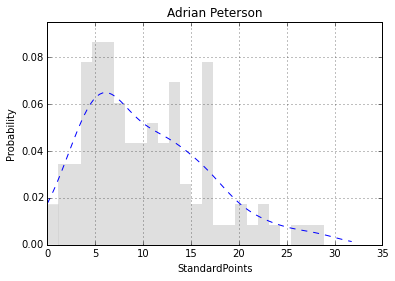

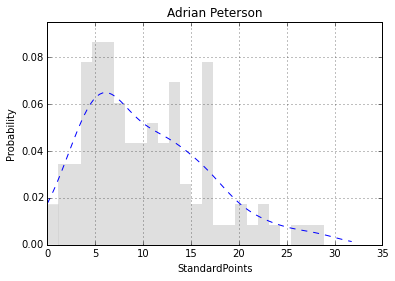

In [14]:
#plot_stat = 'rushing_yds'
plot_stat = 'StandardPoints'

# the histogram of the data
stat_X = check_nn.iloc[1:][plot_stat]
player_name = check_nn.iloc[0]['full_name']
n, bins, patches = plt.hist(stat_X, 25, normed=1, edgecolor='none', facecolor='grey', alpha=0.25)

# get plot limits
xmin = 0
xmax = max(bins)*1.1
ymin = 0
ymax = max(n)*1.1

# get bins for kernel density plot
bins = np.linspace(xmin, xmax, 100)

# set up kernel density
kde = KernelDensity(kernel='gaussian', bandwidth=2.5).fit(X=stat_X[:,np.newaxis])
y_smooth = np.exp(kde.score_samples(bins[:,np.newaxis]))
y_smooth

l = plt.plot(bins, y_smooth, 'b--', linewidth=1)
plt.xlabel(plot_stat)
plt.ylabel('Probability')
plt.axis([0, max(bins)*1.1, 0, max(n)*1.1])
plt.title(player_name)
plt.grid(True)

plt.show()